# Классификация математических задач при помощи bert

In [241]:
import copy

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report

import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW


import transformers
from transformers import AutoModel, AutoTokenizer

from torchinfo import summary

In [242]:
device = 'cuda' if torch.cuda.is_available() else 'CPU'
RANDOM_STATE=2024

## 1. Загрузка датасета и обработка данных

In [243]:
df = pd.read_excel('/kaggle/input/math-problems-dataset/data_problems_translated.xlsx')

In [244]:
df.head()

,Unnamed: 0,problem_text,topic
0,0,To prove that the sum of the numbers of the ex...,number_theory
1,1,( b) Will the statement of the previous challe...,number_theory
2,2,The quadratic three-member graph with the coef...,polynoms
3,3,Can you draw on the surface of Rubik's cube a ...,combinatorics
4,4,"Dima, who came from Vrunlandia, said that ther...",graphs


In [245]:
df.isnull().sum()

Unnamed: 0      0
problem_text    5
topic           0
dtype: int64

In [246]:
df.dropna(inplace=True)

In [247]:
df['topic'].value_counts()

topic
number_theory    2395
combinatorics    1020
dirichlet         441
polynoms          425
graphs            384
geometry          368
invariant         235
Name: count, dtype: int64

**В данноме датасете присутствует дисбаланс классов. Почти половина задач на тему "number theory". Для устранения такого большего дисбаланса проведём недосэмплирование (undersampling), то есть уменьшим количество задач на тему "number theory":**

In [248]:
# возьмём каждую вторую задачу
df_number_theory = df[df['topic'] == 'number_theory']
df_number_theory = df_number_theory.iloc[np.arange(0, df_number_theory.shape[0], 2), :]

# в начале уберём все задачи на тему "number_theory", затем добавим новый уменьшенный список
df_new = df.loc[df['topic'] != 'number_theory', :]
df_new = pd.concat([df_new, df_number_theory])

**Также проведём пересэмплирование (oversampling) для всех классов кроме "number_theory" и "combinatorics":**

In [249]:
for topic in df_new['topic'].unique():
    if topic != 'number_theory' and topic != 'combinatorics':
        df_new = pd.concat([df_new, df_new.loc[df['topic'] == topic, :]])

In [250]:
df_new['topic'].value_counts()

topic
number_theory    1198
combinatorics    1020
dirichlet         882
polynoms          850
graphs            768
geometry          736
invariant         470
Name: count, dtype: int64

**Закодируем темы задач следующим образом:**

In [251]:
topics = df_new['topic'].value_counts().index
d = {column: i for i, column in enumerate(topics)}
N_CLASSES = len(d)
d

{'number_theory': 0,
 'combinatorics': 1,
 'dirichlet': 2,
 'polynoms': 3,
 'graphs': 4,
 'geometry': 5,
 'invariant': 6}

In [252]:
df_new.topic = df_new['topic'].apply(lambda x: d[x])
df_new.head()

,Unnamed: 0,problem_text,topic
2,2,The quadratic three-member graph with the coef...,3
3,3,Can you draw on the surface of Rubik's cube a ...,1
4,4,"Dima, who came from Vrunlandia, said that ther...",4
6,6,Can n sit 2n + 1 round table so that no two si...,4
8,8,The ABC angle triangle is placed in the circle...,5


**Разделим данные на train, validation и test, не забывая про стратификацию:**

In [253]:
df_train, df_val = train_test_split(df_new, stratify=df_new['topic'],
                                    test_size=0.2, random_state=RANDOM_STATE, shuffle=True)
df_val, df_test = train_test_split(df_val, stratify=df_val['topic'],
                                   test_size=0.4, random_state=RANDOM_STATE, shuffle=True)

**Создадим кастомный класс для нашего датасета:**

In [254]:
class ProblemsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, item):
        text = self.texts[item]
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length = self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

**Функция для создания DataLoader:**

In [255]:
def create_dataloader(data, tokenizer_name, batch_size):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    dataset = ProblemsDataset(data.problem_text.to_numpy(), data.topic.to_numpy(), tokenizer)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

## 2. Кастомный класс для модели трансформера

In [256]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model):
        super(TransformerClassificationModel, self).__init__()
        self.backbone = AutoModel.from_pretrained(base_transformer_model)
        self.drop = nn.Dropout(p=0.3)
        self.nonlin = nn.ReLU()
        self.linear = nn.Linear(self.backbone.config.hidden_size, self.backbone.config.hidden_size)
        self.out = nn.Linear(self.backbone.config.hidden_size, N_CLASSES)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask
        )[1]
        outputs = self.drop(pooled_output)
        outputs = self.nonlin(self.linear(outputs))
        outputs = self.out(outputs)
        return outputs

**Напишем функцию для заморозка backbone:**

In [257]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False
    pass

## 3. Функция для дообучения:

**Основная функция для обучения:**

In [258]:
def train_transformer(transformer_model, train_dataloader, val_dataloader,
                      num_epochs, freeze_backbone=True):
    # копируем модель и переносим на device
    model = copy.copy(transformer_model).to(device)
    
    # замораживаем слои backbone
    if freeze_backbone:
        freeze_backbone_function(model)
    
    optimizer = AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss().to(device)
    
    history = {"train_loss": [], "train_acc": [], "val_loss": [],
               "val_acc": [], "train_f1": [], "val_f1": []}
    
    # по f1 будем определять какую модель сохранять
    best_f1 = 0
    
    for i in range(num_epochs):
        
        # train epoch
        f1, accuracy, loss = train_epoch(model, train_dataloader, loss_fn, optimizer, device)
        history['train_loss'].append(loss)
        history['train_acc'].append(accuracy)
        history['train_f1'].append(f1)
        
        # eval epoch
        f1, accuracy, loss = eval_model(model, val_dataloader, loss_fn, device)
        history['val_loss'].append(loss)
        history['val_acc'].append(accuracy)
        history['val_f1'].append(f1)
        
        # сохраняем модель
        if history['val_f1'][-1] > best_f1:
            best_f1 = history['val_f1'][-1]
            torch.save(model.state_dict(), 'model.bin')
        
        # изображаем графики
        draw_res(history)
    
    # загружаем веса лучшей модели        
    model.load_state_dict(torch.load('model.bin'))
    
    return model, history

In [259]:
def train_epoch(model, data_loader, loss_fn,
                optimizer, device):
    
    model = model.train()
    
    losses = []
    correct_predictions = 0
    f1 = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        preds = torch.max(outputs, dim=1)[1]
        loss = loss_fn(outputs, labels)
        
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.cpu().item())
        f1 += f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        optimizer.zero_grad()
    
    batch_size = len(next(iter(data_loader))['labels'])
    
    return f1/len(losses), correct_predictions.double().cpu().item() / (len(losses) * batch_size), np.mean(losses)

In [260]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    
    losses = []
    correct_predictions = 0
    f1 = 0
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask)
            
            preds = torch.max(outputs, dim=1)[1]
            loss = loss_fn(outputs, labels)
            
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.cpu().item())
            f1 += f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='weighted')
            
    
    batch_size = len(next(iter(data_loader))['labels'])
    
    return f1/len(losses), correct_predictions.double().cpu().item() / (len(losses)*batch_size), np.mean(losses)

**Функция для отрисовки графиков лосса, точности и f1 в процессе обучения:**

In [261]:
def draw_res(history):
    k = len(history["train_loss"])
    
    clear_output(wait=True)
    plt.figure(figsize=(18, 6))
        
    plt.subplot(1, 3, 1)
    plt.plot(np.arange(1, k+1), history["train_loss"], label='train loss')
    plt.plot(np.arange(1, k+1), history["val_loss"], label='val loss')
    plt.title('train / validation loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(np.arange(1, k+1), history["train_acc"], label='train acc')
    plt.plot(np.arange(1, k+1), history["val_acc"], label='val acc')
    plt.title('train / validation acc')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(np.arange(1, k+1), history["train_f1"], label='train f1')
    plt.plot(np.arange(1, k+1), history["val_f1"], label='val f1')
    plt.title('train / validation f1')
    plt.legend()

    plt.show()

**Функция для вывода classification report на тестовых данных:**

In [262]:
def test_model(model, data_loader, device):
    model = model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            y_true += d['labels'].tolist()[:]
            labels = d['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask)
            
            y_pred += torch.max(outputs, dim=1)[1].cpu().tolist()[:]
            
    print(classification_report(y_true, y_pred))

## 4. Дообучение bert-tiny с замороженными и размороженными слоями:

In [263]:
model_name = 'prajjwal1/bert-tiny'

In [264]:
train_dataloader = create_dataloader(df_train, model_name, batch_size=16)
val_dataloader = create_dataloader(df_val, model_name, batch_size=16)
test_dataloader = create_dataloader(df_test, model_name, batch_size=16)

**Обучение с размороженными слоями:**

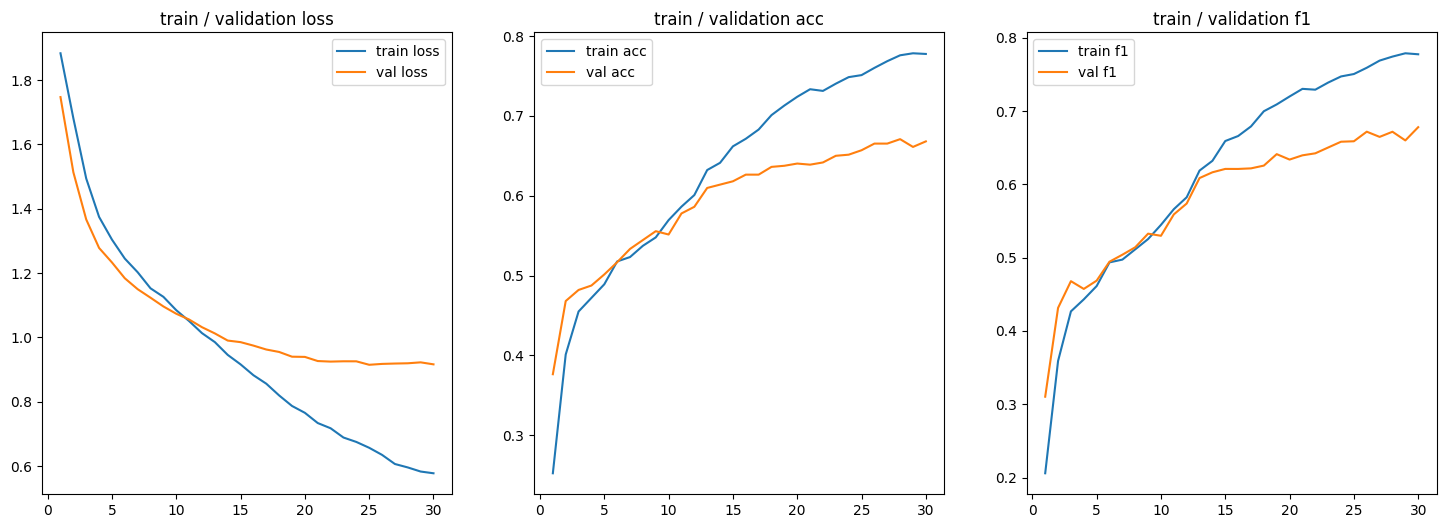

In [265]:
bert_transformer_model = TransformerClassificationModel(model_name);
bert_finetuned_with_unfreezed_backbone, history = train_transformer(bert_transformer_model,
                                                                  train_dataloader,
                                                                  val_dataloader,
                                                                  num_epochs=30,
                                                                  freeze_backbone=False)

In [267]:
test_model(bert_finetuned_with_unfreezed_backbone, test_dataloader, device)

              precision    recall  f1-score   support

           0       0.65      0.55      0.60        96
           1       0.53      0.26      0.35        81
           2       0.59      0.64      0.62        70
           3       0.89      0.94      0.91        68
           4       0.51      0.76      0.61        62
           5       0.91      1.00      0.95        59
           6       0.55      0.68      0.61        38

    accuracy                           0.66       474
   macro avg       0.66      0.69      0.66       474
weighted avg       0.66      0.66      0.65       474



Из таблички видно, что хуже всего у модели получается предсказывать 1 класс, то есть задачи на комбинаторику. Recall маленький следовательно модель часто путает задачи 1 класса с другими, то есть количество false negative большое. Скорей всего дело в том, что задачи по комбинаторике похожи на задачи, например, из темы теория чисел.

**Обучение с замороженными слоями:**

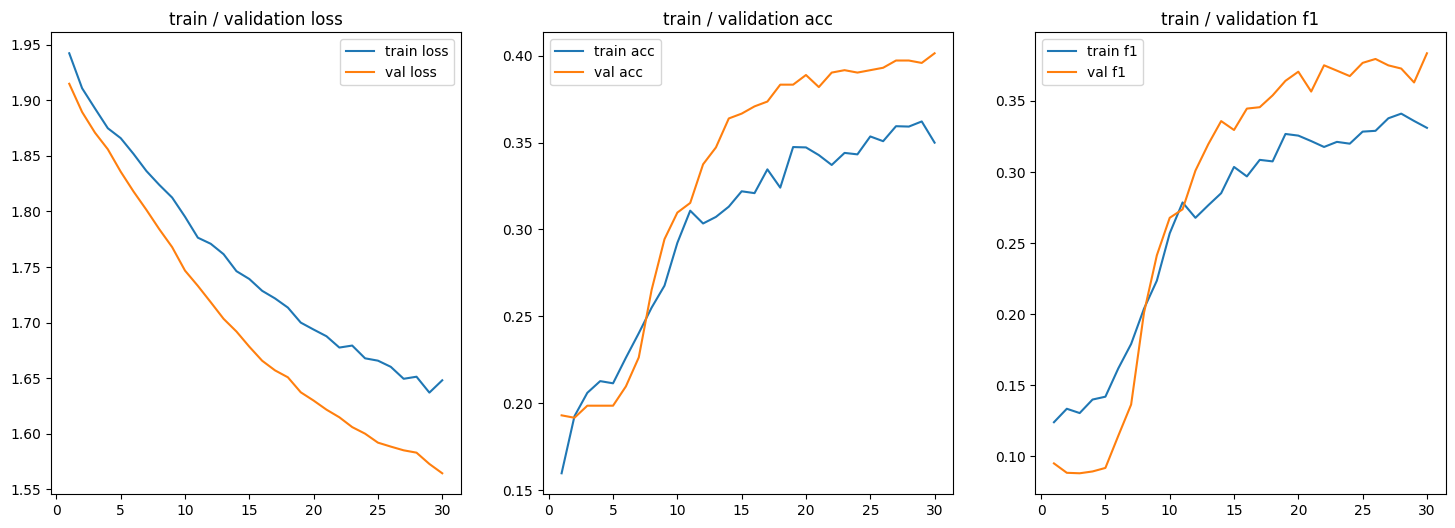

In [268]:
bert_transformer_model = TransformerClassificationModel(model_name);
bert_finetuned_with_freezed_backbone, history = train_transformer(bert_transformer_model,
                                                                  train_dataloader,
                                                                  val_dataloader,
                                                                  num_epochs=30,
                                                                  freeze_backbone=True)

In [269]:
test_model(bert_finetuned_with_freezed_backbone, test_dataloader, device)

              precision    recall  f1-score   support

           0       0.34      0.61      0.44        96
           1       0.26      0.31      0.28        81
           2       0.21      0.07      0.11        70
           3       0.63      0.63      0.63        68
           4       0.37      0.37      0.37        62
           5       0.82      0.71      0.76        59
           6       0.00      0.00      0.00        38

    accuracy                           0.42       474
   macro avg       0.38      0.39      0.37       474
weighted avg       0.39      0.42      0.39       474



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Из таблицы видно, что при замороженных слоях модель дообучается гораздо хуже, что неудивительно, так как мы совсем не меняем веса берта в том числе, связанные вниманием.

## 5. Дообучение MathBert с замороженными и размороженными слоями:

In [270]:
model_name = 'tbs17/MathBert'

In [271]:
train_dataloader = create_dataloader(df_train, model_name, batch_size=16)
val_dataloader = create_dataloader(df_val, model_name, batch_size=16)
test_dataloader = create_dataloader(df_test, model_name, batch_size=16)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

**Обучение с размороженными слоями:**

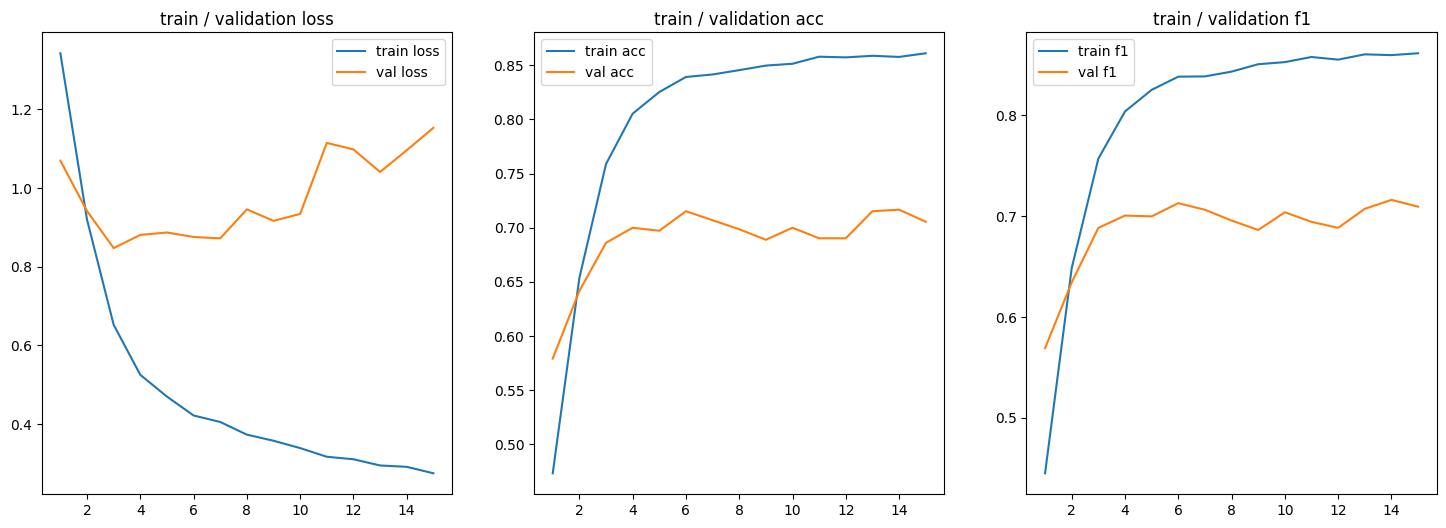

In [272]:
bert_transformer_model = TransformerClassificationModel(model_name);
bert_finetuned_with_freezed_backbone, history = train_transformer(bert_transformer_model,
                                                                  train_dataloader,
                                                                  val_dataloader,
                                                                  num_epochs=15,
                                                                  freeze_backbone=False)

In [273]:
test_model(bert_finetuned_with_freezed_backbone, test_dataloader, device)

              precision    recall  f1-score   support

           0       0.73      0.57      0.64        96
           1       0.52      0.41      0.46        81
           2       0.74      0.76      0.75        70
           3       0.90      0.91      0.91        68
           4       0.56      0.81      0.66        62
           5       0.95      1.00      0.98        59
           6       0.68      0.79      0.73        38

    accuracy                           0.72       474
   macro avg       0.73      0.75      0.73       474
weighted avg       0.72      0.72      0.72       474



Из таблицы видно, что при помощи берта предобученного на большом корпусе математических задач удалось заметно увеличить метрики классификации. Что лишний раз показывает важность выбора правильной модели для конкретной задачи.

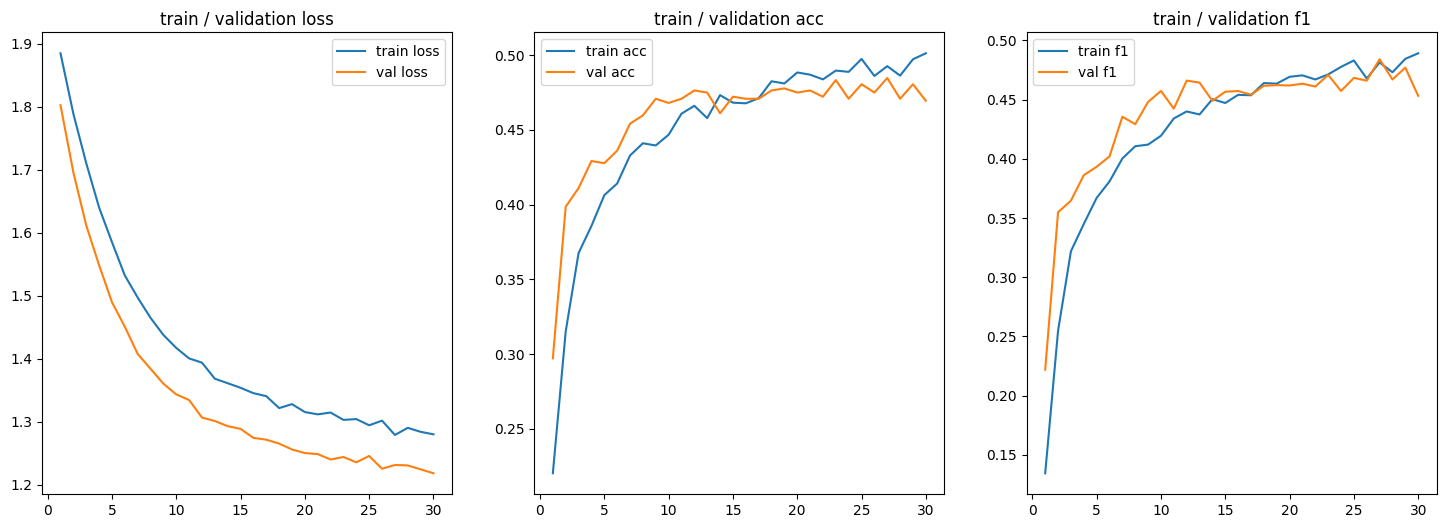

In [276]:
bert_transformer_model = TransformerClassificationModel(model_name);
bert_finetuned_with_freezed_backbone, history = train_transformer(bert_transformer_model,
                                                                  train_dataloader,
                                                                  val_dataloader,
                                                                  num_epochs=30,
                                                                  freeze_backbone=True)

In [277]:
test_model(bert_finetuned_with_freezed_backbone, test_dataloader, device)

              precision    recall  f1-score   support

           0       0.47      0.68      0.56        96
           1       0.33      0.31      0.32        81
           2       0.29      0.29      0.29        70
           3       0.84      0.82      0.83        68
           4       0.54      0.31      0.39        62
           5       0.84      0.97      0.90        59
           6       0.41      0.24      0.30        38

    accuracy                           0.53       474
   macro avg       0.53      0.51      0.51       474
weighted avg       0.52      0.53      0.52       474



Как и для tiny-bert дообученная модель с замороженными слоями хуже предсказывает класс задачи.

## 6. Вывод

В данной работе решалась задача многоклассовой классификации математических задач при помощи дообучения предобученных моделей tiny-bert и MathBert из hugging face. В процессе решения задачи были выполнены следующие этапы:
1. Была решена проблема с дисбалансом классов при помощи сочетания undersampling и oversampling. Здесь также можно было, использовать более изощренные методы, например, сгенерировать дополнительные задачи при помощи тех же языковых моделей или просто дополнительно запарсить из других источников;

2. В качестве основной метрики был выбран f1-weighted, так как она более точно отражает насколько точно модель умеет предсказывать каждый класс. Кроме этого для тестовой выборки выводилась подробная таблица при помощи classification report, которая помогала понять какие именно классы модель предсказывает хорошо, а какие плохо;

3. Была дообучена tiny-bert с замороженными и размороженными слоями. При размороженных слоях удалось добиться наибольшей метрики: f1 = 0.65.

4. Была дообучена Math-bert с замороженными и размороженными слоями. При размороженных слоях удалось добиться f1 = 0.72.

Таким образом, наилучший результат показала дообученная Math-bert с размороженными слоями. Из таблицы classification report, видно что модель лучше всего определяет задачи на темы: принцип Дирихле(2), полиномы(3), геометрия(5) и инвариант(6), а задачи на комбинаторику хуже всего. Это связано с тем, что в некоторых темах в формулировках задач есть уникальные слова(например в геометрии: треугольник, прямой угол и т.д.), которые не присуще другим темам, поэтому модель хорошо предсказывает эти классы, опираясь на эти слова. В некоторых же темах эти ключевые слова сильно перескаются, поэтому их модель путает и в итоге f1-weighted падает.